In [1]:
import os
os.getcwd()


'C:\\Users\\yashw\\OneDrive\\Desktop\\Titanic Survival Classifier (Custom Edition)'

In [2]:
os.listdir()


['.ipynb_checkpoints',
 'data',
 'requirements.txt',
 'Titanic Survival Classifier (Custom Edition).ipynb']

In [3]:
with open("requirements.txt", "w") as f:
    f.write("""pandas
numpy
scikit-learn
seaborn
matplotlib
joblib
""")


In [4]:
import sys
!{sys.executable} -m pip install -r requirements.txt


In [5]:
# Cell 1 - imports and settings
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import joblib

sns.set_style("whitegrid")
%matplotlib inline


In [6]:
# Cell 2 - load data (adjust path if needed)
titanic_df = pd.read_csv("data/Titanic-Dataset.csv")   # change path if your file is in a different folder
print("Rows, Columns:", titanic_df.shape)
titanic_df.head()


Rows, Columns: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# Cell 3 - quick diagnostics
print(titanic_df.info())
display(titanic_df.isnull().sum())
titanic_df.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [8]:
# Cell 4 - feature engineering (create new features with different names)
def get_title(fullname):
    # Extract title from Name (e.g. "Braund, Mr. Owen Harris" -> "Mr")
    if pd.isna(fullname):
        return "Unknown"
    if ',' in fullname and '.' in fullname:
        return fullname.split(',')[1].split('.')[0].strip()
    return "Unknown"

# Title
titanic_df['title'] = titanic_df['Name'].apply(get_title)
# Consolidate rare titles
rare_titles = ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona']
titanic_df['title'] = titanic_df['title'].replace({'Mlle':'Miss','Ms':'Miss','Mme':'Mrs', **{t:'Rare' for t in rare_titles}})

# Deck from Cabin (first letter) - many NaNs -> keep as 'Unknown'
titanic_df['deck'] = titanic_df['Cabin'].astype(str).str[0].replace({'n':'Unknown'})

# Fare per person (divide fare by family size)
titanic_df['family_size'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1
titanic_df['fare_pp'] = titanic_df['Fare'] / titanic_df['family_size']

# Name length (as simple text complexity proxy)
titanic_df['name_len'] = titanic_df['Name'].apply(lambda x: len(str(x)))

# Is child (age < 16)
titanic_df['is_child'] = (titanic_df['Age'] < 16).astype(int)

# Show new columns
titanic_df[['title','deck','family_size','fare_pp','name_len','is_child']].head()


,title,deck,family_size,fare_pp,name_len,is_child
0,Mr,Unknown,2,3.62500,23,0
1,Mrs,C,2,35.64165,51,0
2,Miss,Unknown,1,7.92500,22,0
3,Mrs,C,2,26.55000,44,0
4,Mr,Unknown,1,8.05000,24,0


In [9]:
# Cell 5 - cleaning: drop columns we won't use directly and handle missing Embarked
# We'll keep PassengerId for final output but remove Ticket and raw Cabin/Name columns for modeling.
titanic_for_model = titanic_df.drop(columns=['Ticket','Name','Cabin'], errors='ignore').copy()

# If Embarked has nulls, fill with most frequent for now (we will one-hot encode later)
titanic_for_model['Embarked'].fillna(titanic_for_model['Embarked'].mode()[0], inplace=True)

# Check missing counts now
titanic_for_model.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         0
title            0
deck             0
family_size      0
fare_pp          0
name_len         0
is_child         0
dtype: int64

In [10]:
# Cell 6 - choose features and target (different variable names)
target = 'Survived'

# We'll use a few original features plus engineered ones
features_list = [
    'Pclass','Sex','Age','SibSp','Parch','Fare','Embarked',
    'title','deck','family_size','fare_pp','name_len','is_child'
]

X = titanic_for_model[features_list]
y = titanic_for_model[target]
X.shape, y.shape


((891, 13), (891,))

In [11]:
# Cell 7 - preprocessing pipelines
# Numeric features that may have missing Age, Fare etc.
numeric_feats = ['Age','Fare','SibSp','Parch','family_size','fare_pp','name_len']
# Categorical low-card features
cat_low = ['Pclass','Sex','Embarked','is_child']   # sex we will keep encoded via OneHot here (consistent mapping)
# Categorical higher-card or engineered
cat_high = ['title','deck']

# Numeric transformer: KNN imputer + scaler
numeric_transformer = Pipeline([
    ('knn_imp', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# Categorical transformer: fill missing and one-hot encode
categorical_transformer = Pipeline([
    ('impute_mode', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_feats),
    ('cat1', categorical_transformer, cat_low + cat_high)
], remainder='drop')


In [12]:
# Cell 8 - model pipeline + train/test split
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(random_state=123))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=123)
print("Train / Test shapes:", X_train.shape, X_test.shape)


Train / Test shapes: (712, 13) (179, 13)


In [13]:
# Cell 9 - quick baseline training (default RF)
baseline_rf = pipeline
baseline_rf.fit(X_train, y_train)

y_pred = baseline_rf.predict(X_test)
print("Baseline accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))


Baseline accuracy: 0.8100558659217877
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       110
           1       0.76      0.74      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



In [14]:
# Cell 10 - hyperparameter tuning with RandomizedSearchCV (StratifiedKFold)
param_dist = {
    'clf__n_estimators': [100, 200, 400, 800],
    'clf__max_depth': [None, 6, 10, 16],
    'clf__min_samples_split': [2, 4, 8],
    'clf__min_samples_leaf': [1, 2, 3],
    'clf__max_features': ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
rnd = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=20, cv=cv,
                         scoring='accuracy', n_jobs=-1, random_state=123, verbose=1)

rnd.fit(X_train, y_train)
print("Best score (CV):", rnd.best_score_)
print("Best params:", rnd.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best score (CV): 0.8454545454545455
Best params: {'clf__n_estimators': 200, 'clf__min_samples_split': 8, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 16}


Test accuracy: 0.8212290502793296
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       110
           1       0.78      0.74      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



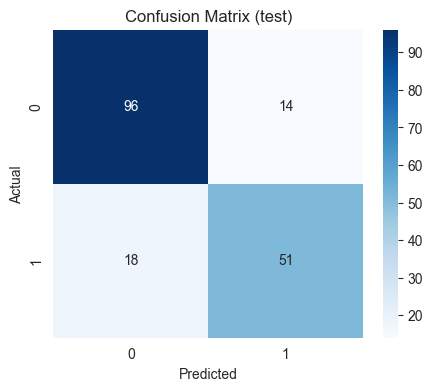

In [15]:
# Cell 11 - evaluate the tuned model
best_pipeline = rnd.best_estimator_
y_test_pred = best_pipeline.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, zero_division=0))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (test)')
plt.show()


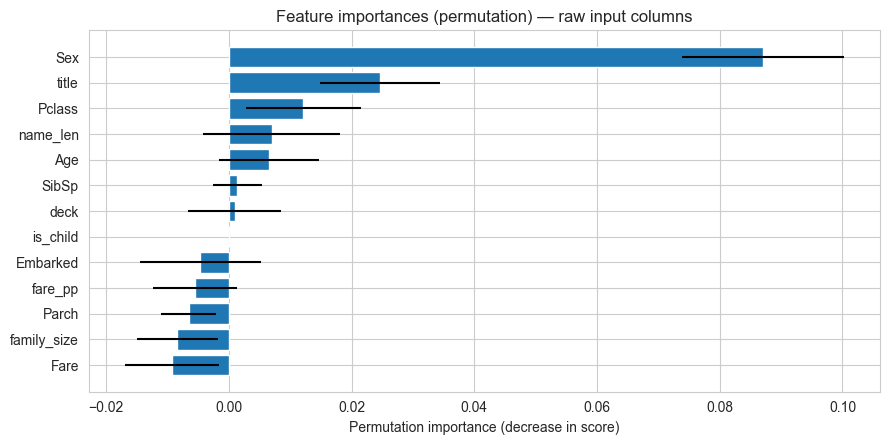

Top features:
      feature  importance_mean  importance_std
1        Sex         0.087058        0.013192
7      title         0.024674        0.009799
0     Pclass         0.012104        0.009357
11  name_len         0.006983        0.011202
2        Age         0.006518        0.008170
3      SibSp         0.001397        0.004032
8       deck         0.000931        0.007507
12  is_child         0.000000        0.000000
6   Embarked        -0.004655        0.009898
10   fare_pp        -0.005587        0.006842


In [16]:
# Final, robust snippet to create the permutation-importance DataFrame and plot it.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

def get_feature_names_from_preprocessor(preproc, input_features):
    """Best-effort extraction of output feature names from a ColumnTransformer/Pipeline."""
    out_names = []
    if hasattr(preproc, "get_feature_names_out"):
        try:
            return list(preproc.get_feature_names_out(input_features))
        except Exception:
            pass

    if hasattr(preproc, "transformers_"):
        for name, transformer, cols in preproc.transformers_:
            if transformer == 'drop' or transformer is None:
                continue
            if transformer == 'passthrough':
                if isinstance(cols, (list, tuple, np.ndarray)):
                    out_names.extend(list(cols))
                else:
                    out_names.append(cols)
                continue

            # If transformer is a pipeline, inspect its last step
            if isinstance(transformer, Pipeline):
                last = transformer.steps[-1][1]
            else:
                last = transformer

            if hasattr(last, "get_feature_names_out"):
                try:
                    # many transformers accept the original col names as argument
                    names = last.get_feature_names_out(cols if isinstance(cols, (list, tuple, np.ndarray)) else [cols])
                except Exception:
                    names = last.get_feature_names_out()
                out_names.extend(list(names))
            else:
                if isinstance(cols, (list, tuple, np.ndarray)):
                    out_names.extend(list(cols))
                else:
                    out_names.append(cols)
    return out_names

# --- Ensure we have permutation importances in `result` ---
try:
    # if result exists from earlier cell, re-use it
    _ = result.importances_mean
except NameError:
    # compute on the pipeline (this permutes the inputs the pipeline expects)
    result = permutation_importance(best_pipeline, X_test, y_test,
                                    n_repeats=12, random_state=123, n_jobs=-1)

# --- Choose appropriate feature names ---
raw_names = list(X_test.columns)
n_importances = len(result.importances_mean)

# Attempt 1: raw names match
if len(raw_names) == n_importances:
    names_to_use = raw_names
    source = "raw input columns"

# Attempt 2: try to recover transformed names from preprocessor
else:
    # find preprocessor step object in pipeline (common names tried)
    preproc = best_pipeline.named_steps.get('preproc') or best_pipeline.named_steps.get('preprocessor') \
             or best_pipeline.named_steps.get('transformer') or None

    if preproc is not None:
        # transform X_test to find number of transformed cols
        Xt = preproc.transform(X_test)
        try:
            n_transformed = Xt.shape[1]
        except Exception:
            n_transformed = np.asarray(Xt).shape[1]

        recovered = get_feature_names_from_preprocessor(preproc, raw_names)
        if len(recovered) == n_importances:
            names_to_use = recovered
            source = "recovered transformed columns"
        elif n_transformed == n_importances and len(recovered) == n_transformed:
            # If importances correspond to transformed matrix, use recovered names
            names_to_use = recovered
            source = "recovered transformed columns (matched transformed shape)"
        else:
            # fallback to positional names
            names_to_use = [f"feature_{i}" for i in range(n_importances)]
            source = "positional fallback (length matched importances)"
    else:
        # no preprocessor found, fallback
        names_to_use = [f"feature_{i}" for i in range(n_importances)]
        source = "positional fallback (no preprocessor found)"

# --- Build DataFrame and plot with error bars ---
imp_df = pd.DataFrame({
    'feature': names_to_use,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values('importance_mean', ascending=True)

plt.figure(figsize=(9, max(4, 0.35 * len(imp_df))))  # height scales with number of features
plt.barh(imp_df['feature'], imp_df['importance_mean'], xerr=imp_df['importance_std'])
plt.xlabel('Permutation importance (decrease in score)')
plt.title(f'Feature importances (permutation) — {source}')
plt.tight_layout()
plt.show()

# Optional: display top-10 most important features
print("Top features:\n", imp_df.sort_values('importance_mean', ascending=False).head(10))


In [18]:
import joblib
import pandas as pd

# 1) load pipeline back
pipe = joblib.load("titanic_pipeline_joblib_v1.pkl")
print("Loaded pipeline:", pipe)

# 2) read the saved csv and inspect
res = pd.read_csv("titanic_predictions_custom.csv")
print("Predictions file shape:", res.shape)
display(res.head())

# 3) quick sanity check: predict on a few original rows and compare to saved csv
sample_X = X.iloc[:5]    # X is the feature dataframe you used earlier
sample_preds = pipe.predict(sample_X)
print("Pipeline predictions (first 5 rows):", sample_preds)
print("Saved predictions (first 5 rows):", res['PredictedSurvived'].iloc[:5].to_list())


Loaded pipeline: Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knn_imp',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'SibSp',
                                                   'Parch', 'family_size',
                                                   'fare_pp', 'name_len']),
                                                 ('cat1',
                                                  Pipeline(steps=[('impute_mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                     

,PassengerId,PredictedSurvived
0,1,0
1,2,1
2,3,1
3,4,1
4,5,0


Pipeline predictions (first 5 rows): [0 1 1 1 0]
Saved predictions (first 5 rows): [0, 1, 1, 1, 0]


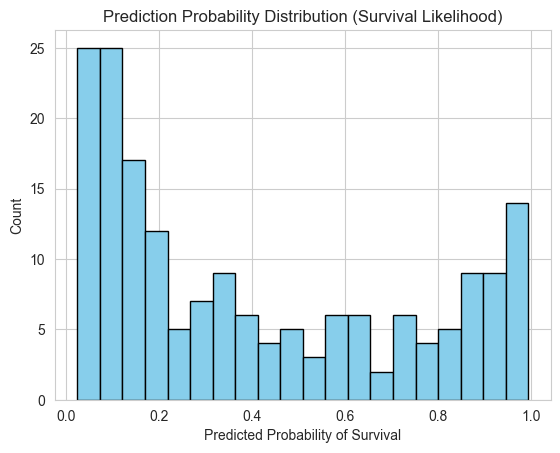

In [19]:
prob = pipe.predict_proba(X_test)[:,1]
plt.hist(prob, bins=20, color='skyblue', edgecolor='black')
plt.title("Prediction Probability Distribution (Survival Likelihood)")
plt.xlabel("Predicted Probability of Survival")
plt.ylabel("Count")
plt.show()


In [20]:
imp_df.sort_values("importance_mean", ascending=False).head(10)


,feature,importance_mean,importance_std
1,Sex,0.087058,0.013192
7,title,0.024674,0.009799
0,Pclass,0.012104,0.009357
11,name_len,0.006983,0.011202
2,Age,0.006518,0.008170
3,SibSp,0.001397,0.004032
8,deck,0.000931,0.007507
12,is_child,0.000000,0.000000
6,Embarked,-0.004655,0.009898
10,fare_pp,-0.005587,0.006842


In [21]:
results_df['Survival_Probability'] = pipe.predict_proba(X)[:,1]
results_df.to_csv("titanic_predictions_with_probs.csv", index=False)
